In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
#Scikit-learn modules
from sklearn.tree  import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import statistics
import xgboost as xgb

In [2]:
train = pd.read_csv("Data/train-data.csv")
test = pd.read_csv("Data/train-data.csv")

In [3]:
df = pd.concat([train, test], ignore_index=True)

In [4]:
df.isna().sum()

Unnamed: 0               0
Name                     0
Location                 0
Year                     0
Kilometers_Driven        0
Fuel_Type                0
Transmission             0
Owner_Type               0
Mileage                  4
Engine                  72
Power                   72
Seats                   84
New_Price            10390
Price                    0
dtype: int64

In [5]:
df.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [6]:
location_dict = {
        'Mumbai':(19.07, 72.87),
        'Pune':(18.52, 73.85),
        'Chennai':(13.08, 80.27),
        'Coimbatore':(11.01, 76.95),
        'Hyderabad': (17.38, 78.48),
        'Jaipur':(26.91, 75.78),
        'Kochi':(9.93, 76.26),
        'Kolkata':(22.57, 88.36),
        'Delhi':(28.70, 77.10),
        'Bangalore':(12.97, 77.59),
        'Ahmedabad':(23.02, 72.57)
        }

def preprocess(x):
    cc_str = str(x["Engine"])[:-3]
    if cc_str != "":
        x["Engine"] = int(cc_str)
    # 0 is out of domain
    # 0 will change with median
    
    tmp = x["Name"].split()
    x["Brand"] = tmp[0]
    x["Model"] = tmp[1]
    
    tmp = location_dict[x["Location"]]
    x["Longitude"] = tmp[0]
    x["Latitude"] = tmp[1]
    
    if x["Power"] != "" and x["Power"] != "null bhp":
        power_str = str(x["Power"]).split()[0]
        x["Power"] = float(power_str)
    else: x["Power"] = 0
    
    if x["Mileage"] != "":
        power_str = str(x["Mileage"]).split()[0]
        x["Mileage"] = float(power_str)
    else: x["Mileage"] = 0
    
    x["Age"] = 2019 - x["Year"]
    
    if x["Owner_Type"] == "First":
        x["Owner_Type"] = 1
    elif x["Owner_Type"] == "Second":
        x["Owner_Type"] = 2
    elif x["Owner_Type"] == "Third":
        x["Owner_Type"] = 3
    elif x["Owner_Type"] == "Fourth & Above":
        x["Owner_Type"] = 4
        
    if x["Fuel_Type"] == "CNG" or x["Fuel_Type"] == "LPG":
        x["Fuel_Type"] = "Gas"
    return x

In [7]:
df = df.apply(preprocess, axis=1)
df.drop(columns=["Name", "Location", "Unnamed: 0", "Year", "New_Price"], inplace=True)

In [8]:
df

,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Brand,Model,Longitude,Latitude,Age
0,72000,Gas,Manual,1,26.60,998.0,58.16,5.0,1.75,Maruti,Wagon,19.07,72.87,9
1,41000,Diesel,Manual,1,19.67,1582.0,126.20,5.0,12.50,Hyundai,Creta,18.52,73.85,4
2,46000,Petrol,Manual,1,18.20,1199.0,88.70,5.0,4.50,Honda,Jazz,13.08,80.27,8
3,87000,Diesel,Manual,1,20.77,1248.0,88.76,7.0,6.00,Maruti,Ertiga,13.08,80.27,7
4,40670,Diesel,Automatic,2,15.20,1968.0,140.80,5.0,17.74,Audi,A4,11.01,76.95,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12033,27365,Diesel,Manual,1,28.40,1248.0,74.00,5.0,4.75,Maruti,Swift,28.70,77.10,5
12034,100000,Diesel,Manual,1,24.40,1120.0,71.00,5.0,4.00,Hyundai,Xcent,26.91,75.78,4
12035,55000,Diesel,Manual,2,14.00,2498.0,112.00,8.0,2.90,Mahindra,Xylo,26.91,75.78,7
12036,46000,Petrol,Manual,1,18.90,998.0,67.10,5.0,2.65,Maruti,Wagon,22.57,88.36,6


In [9]:
df.drop(df[df["Kilometers_Driven"] == df["Kilometers_Driven"].max()].index, inplace=True)
df.drop(df[df["Fuel_Type"] == "Electric"].index, inplace=True)

In [12]:
df.to_pickle("Data/preprocessed_dataframe.pkl")

In [106]:
df = pd.read_pickle("Data/preprocessed_dataframe.pkl")

In [107]:
def fill_median(x):
    # na is replaced with 0 previously
    if x["Power"] == 0:
        x["Power"] = train["Power"].median()

    if x["Mileage"] == 0:
        x["Mileage"] = train["Mileage"].median()
    
    return x
train = train.apply(fill_median, axis=1)

In [108]:
df["Brand"] = df["Brand"].astype("category")
df["Model"] = df["Model"].astype("category")
df["Fuel_Type"] = df["Fuel_Type"].astype("category")
df["Transmission"] = df["Transmission"].astype("category")

In [30]:
return
trans_le = LabelEncoder()
df["Transmission"] = trans_le.fit_transform(df["Transmission"])

ft_le = LabelEncoder()
df["Fuel_Type"] = ft_le.fit_transform(df["Fuel_Type"])

brand_le = LabelEncoder()
df["Brand"] = brand_le.fit_transform(df["Brand"])

model_le = LabelEncoder()
df["Model"] = model_le.fit_transform(df["Model"])

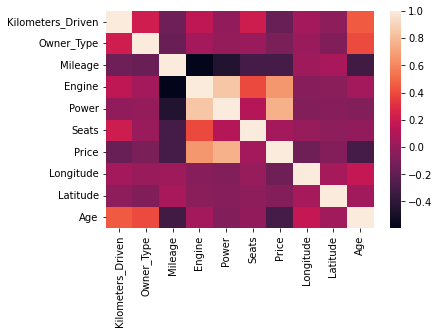

In [109]:
figure = sns.heatmap(df.corr())
# Power and engine has a great correlation can be used together
# Curse of dimensionality can be avoided

In [110]:
df.head()

,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Brand,Model,Longitude,Latitude,Age
0,72000,Gas,Manual,1,26.60,998.0,58.16,5.0,1.75,Maruti,Wagon,19.07,72.87,9
1,41000,Diesel,Manual,1,19.67,1582.0,126.20,5.0,12.50,Hyundai,Creta,18.52,73.85,4
2,46000,Petrol,Manual,1,18.20,1199.0,88.70,5.0,4.50,Honda,Jazz,13.08,80.27,8
3,87000,Diesel,Manual,1,20.77,1248.0,88.76,7.0,6.00,Maruti,Ertiga,13.08,80.27,7
4,40670,Diesel,Automatic,2,15.20,1968.0,140.80,5.0,17.74,Audi,A4,11.01,76.95,6


In [112]:
scaler = StandardScaler()
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_columns = df.select_dtypes(include=numerics).columns
numeric_columns = np.delete(numeric_columns, np.argwhere(numeric_columns == "Price"))
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

In [113]:
df

,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Brand,Model,Longitude,Latitude,Age
0,0.378244,Gas,Manual,-0.444686,1.847294,-1.037315,-0.957299,-0.344737,1.75,Maruti,Wagon,0.182624,-1.084610,1.026889
1,-0.440100,Diesel,Manual,-0.444686,0.334922,-0.065368,0.270238,-0.344737,12.50,Hyundai,Creta,0.089273,-0.844843,-0.502336
2,-0.308109,Petrol,Manual,-0.444686,0.014115,-0.702792,-0.406314,-0.344737,4.50,Honda,Jazz,-0.834060,0.725875,0.721044
3,0.774217,Diesel,Manual,-0.444686,0.574981,-0.621241,-0.405232,2.127601,6.00,Maruti,Ertiga,-0.834060,0.725875,0.415199
4,-0.448811,Diesel,Automatic,1.746332,-0.640591,0.577049,0.533643,-0.344737,17.74,Audi,A4,-1.185402,-0.086397,0.109354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12033,-0.800039,Diesel,Manual,-0.444686,2.240118,-0.621241,-0.671523,-0.344737,4.75,Maruti,Swift,1.817127,-0.049698,-0.196491
12034,1.117393,Diesel,Manual,-0.444686,1.367176,-0.834271,-0.725647,-0.344737,4.00,Hyundai,Xcent,1.513310,-0.372649,-0.502336
12035,-0.070525,Diesel,Manual,1.746332,-0.902474,1.459124,0.014050,3.363771,2.90,Mahindra,Xylo,1.513310,-0.372649,0.415199
12036,-0.308109,Petrol,Manual,-0.444686,0.166880,-1.037315,-0.796009,-0.344737,2.65,Maruti,Wagon,0.776680,2.705176,0.109354


In [114]:
df["Mileage"] = df["Mileage"].fillna(df["Mileage"].median())

In [115]:
df.isna().sum()

Kilometers_Driven     0
Fuel_Type             0
Transmission          0
Owner_Type            0
Mileage               0
Engine               72
Power                72
Seats                84
Price                 0
Brand                 0
Model                 0
Longitude             0
Latitude              0
Age                   0
dtype: int64

In [116]:
imputer = KNNImputer(n_neighbors=1)
df[numeric_columns] = imputer.fit_transform(df[numeric_columns])
df.isna().sum()

Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Price                0
Brand                0
Model                0
Longitude            0
Latitude             0
Age                  0
dtype: int64

In [20]:
imputed_data = imputer.transform(test)
df_temp_test = pd.DataFrame(imputed_data)
df_temp_test.columns = train.columns
df_temp_test.isna().sum()

/opt/homebrew/Caskroom/miniforge/base/envs/dev/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Location
- Name
- New_Price
- Unnamed: 0
- Year
Feature names seen at fit time, yet now missing:
- Age
- Brand
- Latitude
- Longitude
- Model

  warnings.warn(message, FutureWarning)


ValueError: could not convert string to float: 'Maruti Wagon R LXI CNG'

In [117]:
X, y = df.drop(columns="Price"), df["Price"]

In [57]:
bin_num = 6
y_binned = pd.qcut(y, q=bin_num, labels=np.arange(bin_num))

In [93]:
X_train, X_test, y_binned_train, y_binned_test = train_test_split(X, y_binned, test_size = 0.3, random_state = 42, shuffle = True)

NameError: name 'y_binned' is not defined

# Decision Tree

In [263]:
dt = DecisionTreeRegressor(min_samples_leaf=50, random_state=42)

In [264]:
dt.fit(X_train, y_train)

DecisionTreeRegressor(min_samples_leaf=50, random_state=42)

In [265]:
dt.score(X_test, y_test)

0.7945207985723167

In [266]:
mean_squared_error(dt.predict(X_test), y_test)

0.20001602733832727

# Random Forest

In [259]:
reg = RandomForestRegressor(max_depth=30, random_state=42)
reg.fit(X_train, y_train)
y_pred = clf.predict(X_test)
reg.score(X_test, y_test)

0.0455446484498858

In [260]:
mean_squared_error(y_pred, y_test)

0.0455446484498858

In [116]:
rf_scores = dict()
for i in range(1, 40):
    clf = RandomForestClassifier(max_depth=i, random_state=42)
    clf.fit(X_train, y_binned_train)
    rf_scores[i] = clf.score(X_test, y_binned_test)

Text(0, 0.5, 'Classification Score')

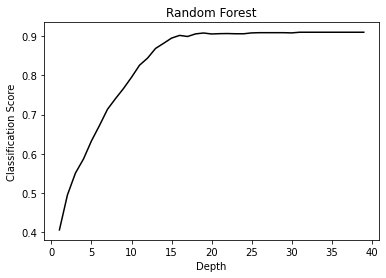

In [235]:
plt.plot(rf_scores.keys(), rf_scores.values(), color="black")
plt.title("Random Forest")
plt.xlabel("Depth")
plt.ylabel("Classification Score")

# XGBOOST

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = True)

In [120]:
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
evallist = [(dtrain, 'train'), (dtest, 'eval')]

In [122]:
xgbr = xgb.XGBRegressor(verbosity=0, enable_categorical=True, tree_method="gpu_hist")
xgbr.fit(X_train, y_train)

XGBoostError: [13:27:23] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/gbm/../common/common.h:239: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000013b8207a8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000013b8c0da0 xgboost::gbm::GBTree::ConfigureUpdaters() + 436
  [bt] (2) 3   libxgboost.dylib                    0x000000013b8c098c xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > >, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > > > > const&) + 964
  [bt] (3) 4   libxgboost.dylib                    0x000000013b8dc87c xgboost::LearnerConfiguration::Configure() + 1016
  [bt] (4) 5   libxgboost.dylib                    0x000000013b8dcb9c xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x000000013b824524 XGBoosterUpdateOneIter + 140
  [bt] (6) 7   libffi.8.dylib                      0x0000000102f3804c ffi_call_SYSV + 76
  [bt] (7) 8   libffi.8.dylib                      0x0000000102f35790 ffi_call_int + 1256
  [bt] (8) 9   _ctypes.cpython-310-darwin.so       0x0000000102f0c42c _ctypes_callproc + 936



In [230]:
xgbr.score(X_test, y_test)

0.9750858169554163

In [251]:
y_test, y_pred

(4412    -0.575741
 10474   -0.686785
 5032    -0.601711
 2611     0.723661
 1562     3.450523
            ...   
 5608    -0.758427
 1765    -0.588278
 5496    -0.552457
 2456    -0.570367
 5665    -0.669770
 Name: Price, Length: 3610, dtype: float64,
 array([-0.594171  , -0.56262094, -0.68631893, ..., -0.55902034,
        -0.50409263, -0.6885315 ], dtype=float32))

In [231]:
y_pred = xgbr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

In [232]:
mse

0.024251777709537913

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

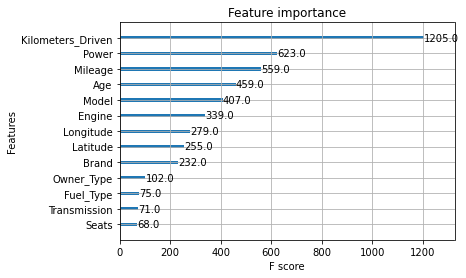

In [233]:
xgb.plot_importance(xgbr)

# XGBOOST with PCA

In [236]:
mse = dict()
score = dict()
for n in range(1, 13):
    pca = PCA(n_components = n)
    pca.fit(X)

    X_pca = pca.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.3, random_state = 42, shuffle = True)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    evallist = [(dtrain, 'train'), (dtest, 'eval')]
    xgbr = xgb.XGBRegressor(verbosity=0) 
    xgbr.fit(X_train, y_train)
    score[n] = xgbr.score(X_test, y_test)
    y_pred = xgbr.predict(X_test)
    mse[n] = mean_squared_error(y_test, y_pred)
    

Text(0.5, 1.0, 'PCA')

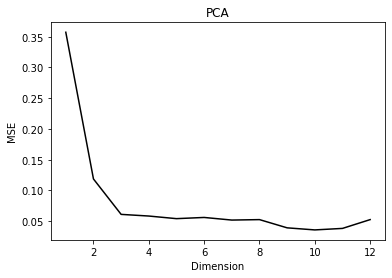

In [241]:
plt.plot(mse.keys(), mse.values(), color="black")
plt.xlabel("Dimension")
plt.ylabel("MSE")
plt.title("PCA")